# Building a Semantic Retrieval System for Book Discovery Using TF-IDF, NMF, and Cosine Similarity

**COSCI210 - Data Mining and Wrangling 1**

**Jose Miguel Bautista, PhD**
  
*Lab Report 2/Final Project*

**<u>MSDS 2026 Learning Team 8, Term 2</u>**

- Francis Erdey M. Capati
   
- Kevin Ansel S. Dy

- Jan Paolo V. Moreno

- Mia Cielo G. Oliveros

## Abstract
This paper presents an end-to-end semantic search pipeline designed to assist bookstore retailers in identifying fiction titles relevant to a customer’s requested themes or topics. Using Penguin Random House’s API as a metadata source, we construct a corpus of fiction titles and apply a multi-stage natural language processing (NLP) workflow. The flap-copy descriptions undergo TF-IDF vectorization, followed by Non-Negative Matrix Factorization (NMF) for topic extraction. A cosine similarity ranking layer enables semantic retrieval, allowing users to submit free-form text queries and receive the most relevant book titles. The resulting system enables accurate, interpretable topic-aligned book recommendations suitable for curation.

## Introduction and Problem Definition

A bookstore customer requests recommendations for titles aligned with specific themes or topics. The objective is to build a semantic retrieval system that returns relevant fiction books from the retailer’s inventory. The challenge is to interpret free-form text queries and identify the most semantically aligned titles using book metadata.

## Data Acquisition from Penguin Random House API

The corpus is constructed from Penguin Random House’s metadata service, accessed via a secure API key.

2.1. Collecting Fiction Category Identifiers

Fiction BISAC categories are retrieved from PRH endpoints and stored locally in a JSON file for reference.

These category IDs form the basis for selecting relevant books to include in the corpus.

2.2. Batch Retrieval of Title Metadata
A custom function accepts:

A list of category IDs

A record count per category

A set of API parameters

The function returns a list of data frames, each containing:

|ISBN|
|--|
|Title|
|Author|
|Flap-copy description|

These fields form the raw text corpus for downstream NLP processing.

In [22]:
!pip install nltk --quiet

In [23]:
import requests
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from scipy import sparse
import json
import re
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import sys
!{sys.executable} -m pip install optuna
import optuna
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from wordcloud import STOPWORDS
from wordcloud import WordCloud

API_KEY = "fh5hj47dynk4nvx4s9ewufj4"
BASE = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca"
CAT = "https://api.penguinrandomhouse.com/resources/v2/domains/PRH.US/categories/"
TITLE_CAT = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/"
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
session = requests.Session()


'c:\Users\olive\OneDrive\Documents\AIM\Term' is not recognized as an internal or external command,
operable program or batch file.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [24]:
BISAC = pd.read_json("bisac_prefixes.json", typ="series").reset_index()
BISAC.columns = ["prefix", "category"]
BISAC

,prefix,category
0,ANT,Antiques & Collectibles
1,ARC,Architecture
2,BIB,Bibles
3,BIO,Biography & Autobiography
4,BOD,"Body, Mind & Spirit"
5,BUS,Business & Economics
6,CGN,Comics & Graphic Novels
7,COM,Computers
8,CKB,Cooking
9,CRA,Crafts & Hobbies


In [25]:
with open('fiction_BISAC.json', 'r') as f:
    fiction_bisac_codes = json.load(f)
fiction_bisac_codes = fiction_bisac_codes.get('data')
fiction_bisac_codes
f_cat_map = {
    c["catId"]: c["menuText"]
    # c["catId"]: {
    #     "BISAC": c["catUri"],
    #     "Description": c["menuText"]
        for c in fiction_bisac_codes["categories"]
}
f_cat_map

{3000001525: 'Fiction',
 3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001544: 'Christian',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001551: 'Historical',
 3000001552: 'Romance',
 3000001553: 'Historical',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',

In [26]:
len(f_cat_map)

369

In [27]:
f_cat_id = {}
for key, value in f_cat_map.items():
    if value not in f_cat_id.values():
        f_cat_id[key] = value

f_cat_id

{3000001525: 'Fiction',
 3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001552: 'Romance',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',
 3000001559: 'Classics',
 3000001560: 'Coming Of Age',
 3000001561: 'Crime',
 3

In [28]:
len(f_cat_id)

257

In [29]:
del f_cat_id[3000001525]
f_cat_id

{3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001552: 'Romance',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',
 3000001559: 'Classics',
 3000001560: 'Coming Of Age',
 3000001561: 'Crime',
 3000001562: 'Cultural Her

Building The Corpus

In [30]:
# Build Corpus only in memory
def build_corpus(f_cat_id, rows=20):
    API_KEY = "fh5hj47dynk4nvx4s9ewufj4"
    BASE = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca"
    CAT = "https://api.penguinrandomhouse.com/resources/v2/domains/PRH.US/categories/"
    session = requests.Session()

    results = []
    for catId in f_cat_id:

        params = {
            "formatFamily": "Paperback",
            "catId": catId,
            "showFlapCopy": "true",
            "showPublishedBooks": "true",
            "start": 0,
            "rows": rows,
            "language": 'E',
            "api_key": API_KEY,
        }

        try:
            r = session.get(BASE, params=params, timeout=20)
            r.raise_for_status()

        except requests.exceptions.Timeout:
            #print(f"\n[TIMEOUT] Category {catId} timed out. Skipping.")
            continue

        except requests.exceptions.ConnectionError:
            #print(f"\n[CONNECTION ERROR] Failed to connect for category {catId}. Skipping.")
            continue

        except requests.exceptions.HTTPError as http_err:
            #print(f"\n[HTTP ERROR] Category {catId}: {http_err}. Skipping.")
            continue

        except Exception as e:
            #print(f"\n[UNKNOWN ERROR] Category {catId}: {e}. Skipping.")
            continue

        #print("\n---")
        #print("CATID:", catId)
        #print("STATUS:", r.status_code)
        #print("URL:", r.url)
        #print("RAW:", r.text[:200])

        r.raise_for_status()
        r_dict = r.json()
        for i in r_dict['data']:
            i['catId'] = catId
        results.append(r_dict)

    
    # Build the dataframe
    corpus = pd.DataFrame(results[0]['data'])
    #catid_corpus_dict = {}

    for catid in results:
        df = pd.DataFrame(catid['data'])
        try:
            corpus = pd.concat([corpus, df], ignore_index=True)
            #catid_corpus_dict[catid['params']['catId']] = len(catid['data'])
        except NameError:
            corpus = df

    corpus = corpus.drop(columns=['isbnHyphenated', 'workId', 'coverUrl',
        'format', 'subformat', 'binding', 'editionTarget', 'trim', 'edition',
        'onSaleDate', 'exportOnSaleDate', 'price', 'exportPrice',
        'globalDivision', 'publishingDivision', 'imprint', 'publishingStatus',
        'series', 'language', 'seq', 'titleBlock', 'authors'])

    return corpus

In [31]:
# # Build Corpus only and store as a JSON file
# def build_corpus_to_json(f_cat_id, rows=20, outfile="corpus.json"):
#     API_KEY = "fh5hj47dynk4nvx4s9ewufj4"
#     BASE = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca"
#     session = requests.Session()

#     all_records = []

#     for catId in f_cat_id:

#         params = {
#             "formatFamily": "Paperback",
#             "catId": catId,
#             "showFlapCopy": "true",
#             "showPublishedBooks": "true",
#             "start": 0,
#             "rows": rows,
#             "language": "E",
#             "api_key": API_KEY,
#         }

#         try:
#             r = session.get(BASE, params=params, timeout=20)
#             r.raise_for_status()
#         except Exception:
#             continue

#         data = r.json().get("data", [])

#         # Tag each record with its category
#         for entry in data:
#             entry["catId"] = catId
#             all_records.append(entry)

#     # Save to JSON file
#     with open(outfile, "w", encoding="utf-8") as f:
#         json.dump(all_records, f, indent=2, ensure_ascii=False)

#     print(f"Saved {len(all_records)} records to {outfile}")

#     # Optional: also return as DataFrame
#     corpus_df = pd.DataFrame(all_records)

#     # Drop unnecessary PRH columns if present
#     drop_cols = [
#         "isbnHyphenated", "workId", "coverUrl", "format", "subformat",
#         "binding", "editionTarget", "trim", "edition", "onSaleDate",
#         "exportOnSaleDate", "price", "exportPrice", "globalDivision",
#         "publishingDivision", "imprint", "publishingStatus", "series",
#         "language", "seq", "titleBlock", "authors"
#     ]

#     corpus_df = corpus_df.drop(columns=[c for c in drop_cols if c in corpus_df.columns], errors="ignore")

#     return corpus_df

In [32]:
# corpus = build_corpus_to_json(f_cat_id=f_cat_id, rows=100, outfile="fiction_corpus.json")

In [33]:
corpus = build_corpus(f_cat_id, rows=100)
corpus

,isbn,title,author,description,catId
0,9780140154078,The Music of Chance,Paul Auster,<b>An &ldquo;exceptional&rdquo; (<i>Los Angele...,3000001526
1,9780142001813,Homo Zapiens,Victor Pelevin,The collapse of the Soviet Union has opened up...,3000001526
2,9780241678916,The Castle,Franz Kafka; Translated by J. A. Underwood; In...,<b>An acclaimed translation of the final work ...,3000001526
3,9780425253373,Lunatics,Dave Barry,"<b>Philip Horkman is a happy man, the owner of...",3000001526
4,9780451203069,Cosmic Banditos,A. C. Weisbecker,Soon to be a major motion picture starring <b>...,3000001526
...,...,...,...,...,...
11304,9781681377964,Waiting for the Fear,"Oguz Atay, translated from the Turkish by Ralp...","<b>Short stories about people on the margins, ...",3000001915
11305,9781892746931,The Prisoner of Ankara,Suat Dervis,<b>An idealistic young man attempts to find hi...,3000001915
11306,9781953861382,Dawn,Sevgi Soysal,<b>A searing autobiographical novel about a si...,3000001915
11307,9781939810465,A Dream Come True,Juan Carlos Onetti,<b><i>A Dream Come True </i>collects the compl...,3000001916


Pre-Processing

In [34]:
catcounts = corpus['catId'].value_counts()
corpus['catcounts'] = corpus['catId'].map(catcounts)
corpus

,isbn,title,author,description,catId,catcounts
0,9780140154078,The Music of Chance,Paul Auster,<b>An &ldquo;exceptional&rdquo; (<i>Los Angele...,3000001526,172
1,9780142001813,Homo Zapiens,Victor Pelevin,The collapse of the Soviet Union has opened up...,3000001526,172
2,9780241678916,The Castle,Franz Kafka; Translated by J. A. Underwood; In...,<b>An acclaimed translation of the final work ...,3000001526,172
3,9780425253373,Lunatics,Dave Barry,"<b>Philip Horkman is a happy man, the owner of...",3000001526,172
4,9780451203069,Cosmic Banditos,A. C. Weisbecker,Soon to be a major motion picture starring <b>...,3000001526,172
...,...,...,...,...,...,...
11304,9781681377964,Waiting for the Fear,"Oguz Atay, translated from the Turkish by Ralp...","<b>Short stories about people on the margins, ...",3000001915,6
11305,9781892746931,The Prisoner of Ankara,Suat Dervis,<b>An idealistic young man attempts to find hi...,3000001915,6
11306,9781953861382,Dawn,Sevgi Soysal,<b>A searing autobiographical novel about a si...,3000001915,6
11307,9781939810465,A Dream Come True,Juan Carlos Onetti,<b><i>A Dream Come True </i>collects the compl...,3000001916,1


In [35]:
corpus = corpus[corpus['catcounts'] >= 50].reset_index(drop=True)
corpus

,isbn,title,author,description,catId,catcounts
0,9780140154078,The Music of Chance,Paul Auster,<b>An &ldquo;exceptional&rdquo; (<i>Los Angele...,3000001526,172
1,9780142001813,Homo Zapiens,Victor Pelevin,The collapse of the Soviet Union has opened up...,3000001526,172
2,9780241678916,The Castle,Franz Kafka; Translated by J. A. Underwood; In...,<b>An acclaimed translation of the final work ...,3000001526,172
3,9780425253373,Lunatics,Dave Barry,"<b>Philip Horkman is a happy man, the owner of...",3000001526,172
4,9780451203069,Cosmic Banditos,A. C. Weisbecker,Soon to be a major motion picture starring <b>...,3000001526,172
...,...,...,...,...,...,...
9574,9781805335238,The Black Swan Mystery,Tetsuya Ayukawa,<b>THE JAPANESE CRIME FICTION CLASSIC: A prize...,3000001885,62
9575,9781805335436,The Man Who Died Seven Times,Yasuhiko Nishizawa,<b>A&nbsp;subversively&nbsp;cozy Japanese murd...,3000001885,62
9576,9781805335511,Murder at the Black Cat Café,Seishi Yokomizo,<b>FROM ONE OF JAPAN'S GREATEST CRIME WRITERS&...,3000001885,62
9577,9781839768491,Hit Parade of Tears,Izumi Suzuki,<b>A new collection of stories from the cult a...,3000001885,62


In [36]:
corpus = corpus.drop_duplicates(subset=['title'], keep='first').reset_index(drop=True)
corpus

,isbn,title,author,description,catId,catcounts
0,9780140154078,The Music of Chance,Paul Auster,<b>An &ldquo;exceptional&rdquo; (<i>Los Angele...,3000001526,172
1,9780142001813,Homo Zapiens,Victor Pelevin,The collapse of the Soviet Union has opened up...,3000001526,172
2,9780241678916,The Castle,Franz Kafka; Translated by J. A. Underwood; In...,<b>An acclaimed translation of the final work ...,3000001526,172
3,9780425253373,Lunatics,Dave Barry,"<b>Philip Horkman is a happy man, the owner of...",3000001526,172
4,9780451203069,Cosmic Banditos,A. C. Weisbecker,Soon to be a major motion picture starring <b>...,3000001526,172
...,...,...,...,...,...,...
7275,9781805335214,Murder in the House of Omari,Taku Ashibe,<b>Use your powers of logic and deduction to s...,3000001885,62
7276,9781805335238,The Black Swan Mystery,Tetsuya Ayukawa,<b>THE JAPANESE CRIME FICTION CLASSIC: A prize...,3000001885,62
7277,9781805335511,Murder at the Black Cat Café,Seishi Yokomizo,<b>FROM ONE OF JAPAN'S GREATEST CRIME WRITERS&...,3000001885,62
7278,9781839768491,Hit Parade of Tears,Izumi Suzuki,<b>A new collection of stories from the cult a...,3000001885,62


In [37]:
def lemmatize_text(text):
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens]
    return " ".join(lemmas)

In [38]:
# 1. Clean HTML, entities, digits
corpus.loc[:, 'description'] = (
    corpus['description']
        .str.replace(r"<.*?>", "", regex=True)            # remove HTML tags
        .str.replace(r"&[A-Za-z0-9#]+;", "", regex=True)  # remove HTML entities
        .str.replace(r"\d+", "", regex=True)              # drop digits
        .str.strip()
)

# 2. Lemmatize (apply only AFTER cleaning)
corpus['description'] = corpus['description'].apply(lemmatize_text)

corpus

,isbn,title,author,description,catId,catcounts
0,9780140154078,The Music of Chance,Paul Auster,an exceptional ( los angeles time ) novel of f...,3000001526,172
1,9780142001813,Homo Zapiens,Victor Pelevin,the collapse of the soviet union ha opened up ...,3000001526,172
2,9780241678916,The Castle,Franz Kafka; Translated by J. A. Underwood; In...,an acclaimed translation of the final work by ...,3000001526,172
3,9780425253373,Lunatics,Dave Barry,"philip horkman is a happy man , the owner of a...",3000001526,172
4,9780451203069,Cosmic Banditos,A. C. Weisbecker,soon to be a major motion picture starring joh...,3000001526,172
...,...,...,...,...,...,...
7275,9781805335214,Murder in the House of Omari,Taku Ashibe,use your power of logic and deduction to solve...,3000001885,62
7276,9781805335238,The Black Swan Mystery,Tetsuya Ayukawa,the japanese crime fiction classic : a prize-w...,3000001885,62
7277,9781805335511,Murder at the Black Cat Café,Seishi Yokomizo,from one of japan 's greatest crime writersthe...,3000001885,62
7278,9781839768491,Hit Parade of Tears,Izumi Suzuki,a new collection of story from the cult author...,3000001885,62


## Exploratory Data Analysis

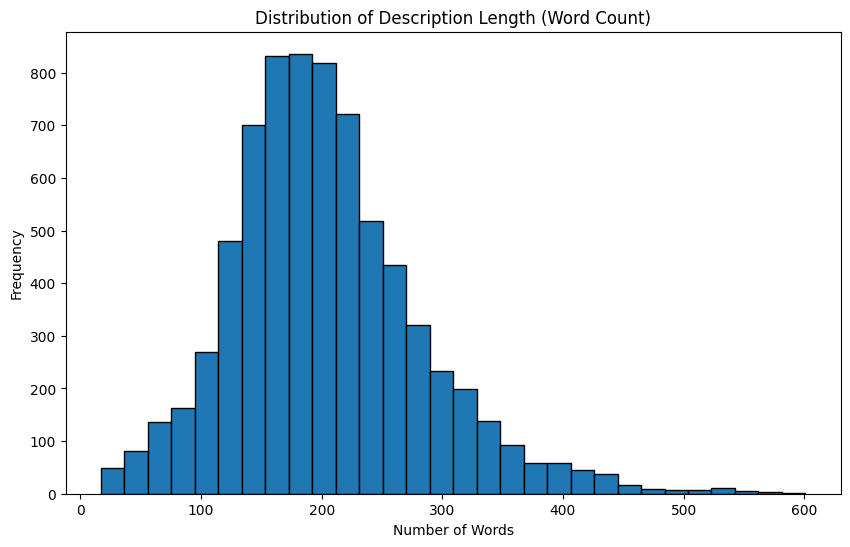

In [39]:
# Compute word counts
word_counts = corpus['description'].str.split().str.len()

plt.figure(figsize=(10,6))
plt.hist(word_counts, bins=30, edgecolor='black')
plt.title('Distribution of Description Length (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [40]:
# Mean description length
int(corpus['description'].str.split().str.len().mean())

203

In [42]:
# Lowercase and remove punctuation (WordCloud-style)
cleaned = corpus['description'].str.lower().str.replace(r"[^\w\s]", " ", regex=True)

# Split and explode
words = cleaned.str.split().explode()

# Remove stopwords
filtered = words[~words.isin(STOPWORDS)]

# Remove very short junk tokens (WordCloud does this)
filtered = filtered[filtered.str.len() > 2]

# Get top 20
top_20 = filtered.value_counts().head(20)
top_20

description
new       6236
one       5136
life      4974
time      4489
novel     3885
world     3761
will      3537
author    3410
love      3229
story     3212
year      3203
woman     2904
york      2772
book      2725
find      2644
family    2637
man       2242
now       2188
first     2083
best      1923
Name: count, dtype: int64

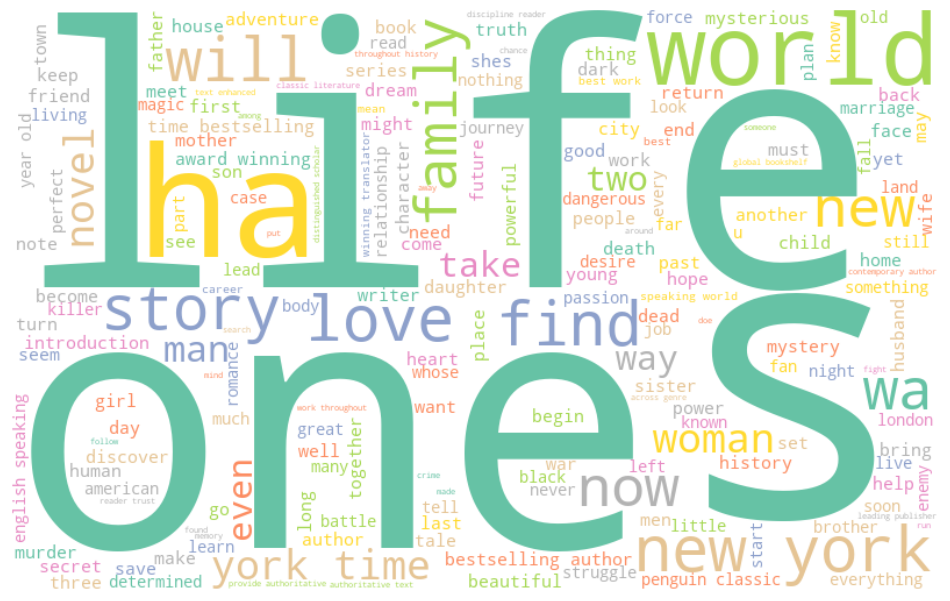

In [43]:
# Generate Word Cloud
desc_column = corpus['description']
words = desc_column.str.cat(sep=' ')

# Create a prettier word cloud
wordcloud = WordCloud(
    width=800,
    height=500,
    background_color="white",     # clean white background
    colormap="Set2",            # soft, professional color palette
    max_words=200,
    prefer_horizontal=0.9,        # mostly horizontal words → easier to read
    random_state=42               # consistent colors/layout
).generate(words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

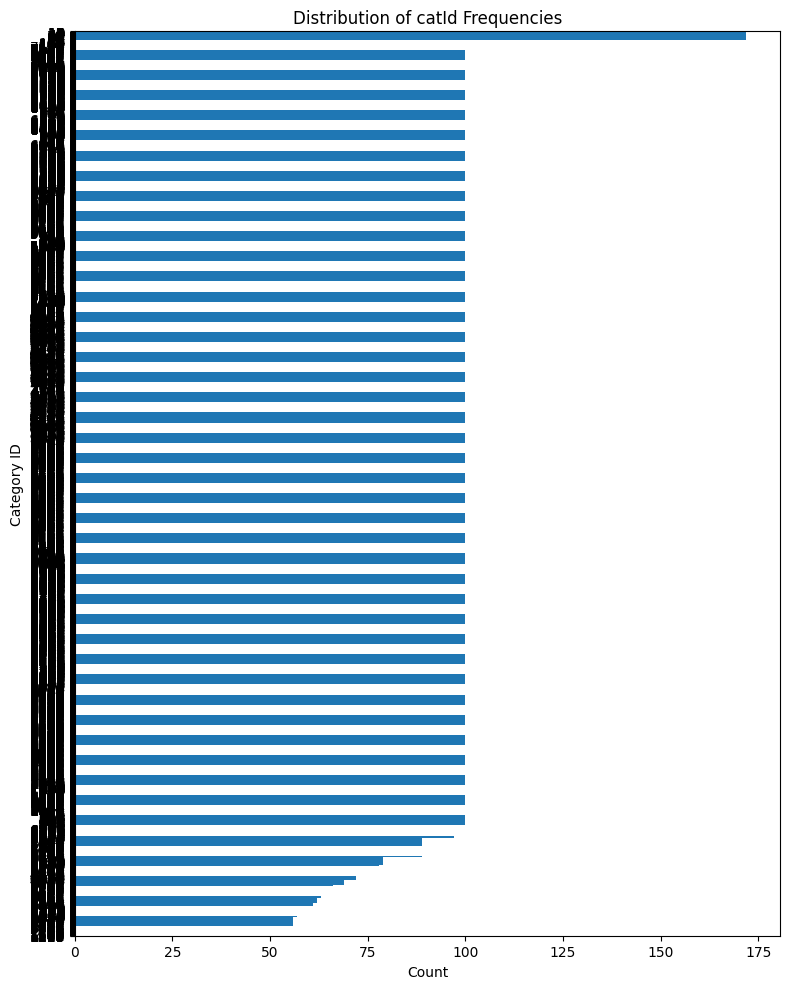

In [60]:
plt.figure(figsize=(8,10))
corpus['catcounts'].sort_values().plot(kind='barh')
plt.xlabel("Count")
plt.ylabel("Category ID")
plt.title("Distribution of catId Frequencies")
plt.tight_layout()
plt.show()

#### Confine to Description

In [61]:
# Focus on descriptions only
working_corpus = corpus['description']
working_corpus

0       an exceptional ( los angeles time ) novel of f...
1       the collapse of the soviet union ha opened up ...
2       an acclaimed translation of the final work by ...
3       philip horkman is a happy man , the owner of a...
4       soon to be a major motion picture starring joh...
                              ...                        
7275    use your power of logic and deduction to solve...
7276    the japanese crime fiction classic : a prize-w...
7277    from one of japan 's greatest crime writersthe...
7278    a new collection of story from the cult author...
7279    the akutagawa prize-winning novel by kou machi...
Name: description, Length: 7280, dtype: object

## Bag-of-Words

In [ ]:
vectorizer = CountVectorizer()
X_sparse = vectorizer.fit_transform(working_corpus)


columns = vectorizer.get_feature_names_out()
df = pd.DataFrame.sparse.from_spmatrix(X_sparse, columns=columns)
df = df.join(corpus['catId'])

X = df.drop(columns=['catId']).to_numpy()
y = df['catId'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda.score(X_train, y_train)
lda.score(X_test, y_test)

0.20467032967032966

## TF-IDF Vectorization of Flap-Copy Descriptions

TF-IDF is applied to the book descriptions to numerically encode text.

Term Frequency (TF): Measures how often a word appears within a document, reflecting document-specific importance.

Inverse Document Frequency (IDF): Penalizes common words across the corpus while boosting rare, topic-specific terms.

The resulting sparse TF-IDF matrix serves as the foundation for topic modeling.

#### Step 2. Perform TF-IDF on corpus

In [63]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english',
                             min_df=3,
                             max_df=0.6)
tfidf_matrix = vectorizer.fit_transform(working_corpus)

# Get the feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array for easier viewing (for small datasets)
dense_matrix = tfidf_matrix.toarray()

# Create a DataFrame for better readability
tf_idf_df = pd.DataFrame(dense_matrix, columns=feature_names)
tf_idf_df

,aapi,aaron,ab,abaddons,abandon,abandoned,abandoning,abandonment,abbess,abbey,...,zola,zombie,zonama,zone,zoo,zook,zoom,zora,zuckerman,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


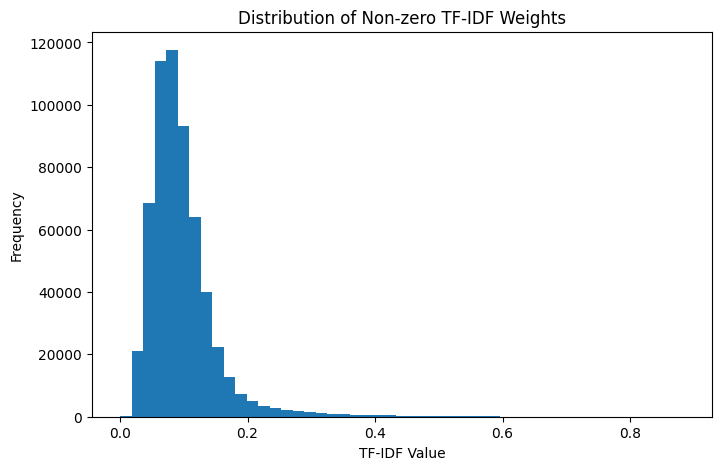

In [21]:
# Extract the non-zero TF-IDF weights (MUCH FASTER than dense)
tfidf_values = tfidf_matrix.data   # only non-zero entries

# Create bins
bins = np.linspace(0, tfidf_values.max(), 50)  # 50 bins

plt.figure(figsize=(8,5))
plt.hist(tfidf_values, bins=bins)
plt.xlabel("TF-IDF Value")
plt.ylabel("Frequency")
plt.title("Distribution of Non-zero TF-IDF Weights")
plt.show()

In [22]:
tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])

0.0043654111949578845

Train ML Models without DR

In [23]:
# X is TF-IDF matrix
X = tf_idf_df.copy()

# y is the catId column from the corpus
y = corpus['catId'].astype(str).values

# Encode labels (LogReg/SVM require numerical y)
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

In [25]:
# -----------------------------
# 0) Data prep (TF-IDF already built)
# -----------------------------
# X: tf_idf_df (pandas DataFrame), y: corpus['catId']
X = tf_idf_df.values
y_raw = corpus['catId'].astype(str).values

# Encode labels to integers
le = LabelEncoder()
y = le.fit_transform(y_raw)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -----------------------------
# 1) Optuna objectives (optimize macro F1)
# -----------------------------
def objective_logreg(trial):
    C = trial.suggest_float("C", 1e-4, 10.0, log=True)
    penalty = "l2"  # use lbfgs with l2
    solver = "lbfgs"

    mdl = LogisticRegression(
        C=C, penalty=penalty, solver=solver,
        max_iter=3000, n_jobs=-1
    )
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    return f1_score(y_test, preds, average="macro")

def objective_linearsvc(trial):
    C = trial.suggest_float("C", 1e-4, 10.0, log=True)
    mdl = LinearSVC(C=C)
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)
    return f1_score(y_test, preds, average="macro")

# NOTE: GMM needs dense, low-dim inputs. We apply a small SVD INSIDE this objective only.
def objective_gmm(trial):
    svd_dim = trial.suggest_int("svd_dim", 50, 200)  # compact space for GMM
    n_components = trial.suggest_int("n_components", 20, 120)  # you have 87 classes
    cov_type = trial.suggest_categorical("covariance_type", ["spherical", "diag", "tied", "full"])

    svd = TruncatedSVD(n_components=svd_dim, random_state=42)
    Xtr = svd.fit_transform(X_train)
    Xte = svd.transform(X_test)

    gmm = GaussianMixture(
        n_components=n_components,
        covariance_type=cov_type,
        random_state=42
    )
    gmm.fit(Xtr)

    # Cluster→label mapping via majority vote on training set
    cl_train = gmm.predict(Xtr)
    cl_test = gmm.predict(Xte)

    cluster_to_label = {}
    for c in np.unique(cl_train):
        mask = (cl_train == c)
        if mask.sum() == 0:
            cluster_to_label[c] = -1
        else:
            cluster_to_label[c] = np.bincount(y_train[mask]).argmax()

    preds = np.array([cluster_to_label.get(c, -1) for c in cl_test])
    return f1_score(y_test, preds, average="macro")

# -----------------------------
# 2) Run studies
# -----------------------------
trials = 10
study_log = optuna.create_study(direction="maximize", study_name="logreg_tfidf")
study_log.optimize(objective_logreg, n_trials=trials, show_progress_bar=False)

study_svm = optuna.create_study(direction="maximize", study_name="linearsvc_tfidf")
study_svm.optimize(objective_linearsvc, n_trials=trials, show_progress_bar=False)

study_gmm = optuna.create_study(direction="maximize", study_name="gmm_svd_tfidf")
study_gmm.optimize(objective_gmm, n_trials=trials, show_progress_bar=False)

print("Best (LogReg):", study_log.best_value, study_log.best_params)
print("Best (LinearSVC):", study_svm.best_value, study_svm.best_params)
print("Best (GMM):", study_gmm.best_value, study_gmm.best_params)

# -----------------------------
# 3) Train best models on train; evaluate on test
# -----------------------------
# Logistic Regression
best_log = LogisticRegression(
    C=study_log.best_params["C"],
    penalty="l2", solver="lbfgs", max_iter=3000, n_jobs=-1
).fit(X_train, y_train)
pred_log = best_log.predict(X_test)

# Linear SVM
best_svm = LinearSVC(
    C=study_svm.best_params["C"]
).fit(X_train, y_train)
pred_svm = best_svm.predict(X_test)

# GMM (+ SVD as found)
svd_dim = study_gmm.best_params["svd_dim"]
svd = TruncatedSVD(n_components=svd_dim, random_state=42)
Xtr = svd.fit_transform(X_train)
Xte = svd.transform(X_test)

best_gmm = GaussianMixture(
    n_components=study_gmm.best_params["n_components"],
    covariance_type=study_gmm.best_params["covariance_type"],
    random_state=42
).fit(Xtr)

cl_train = best_gmm.predict(Xtr)
cl_test = best_gmm.predict(Xte)

cluster_to_label = {}
for c in np.unique(cl_train):
    mask = (cl_train == c)
    if mask.sum() == 0:
        cluster_to_label[c] = -1
    else:
        cluster_to_label[c] = np.bincount(y_train[mask]).argmax()

pred_gmm = np.array([cluster_to_label.get(c, -1) for c in cl_test])

# -----------------------------
# 4) Metrics
# -----------------------------
def summarize(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

results = pd.DataFrame({
    "LogisticRegression": summarize(y_test, pred_log),
    "LinearSVM": summarize(y_test, pred_svm),
    "GMM(SVD-inside)": summarize(y_test, pred_gmm)
}).T

print("\n=== MODEL PERFORMANCE (TF-IDF ONLY) ===")
print(results.sort_values("f1_macro", ascending=False))

[I 2025-11-23 16:04:36,188] A new study created in memory with name: logreg_tfidf
[I 2025-11-23 16:04:52,058] Trial 0 finished with value: 0.00027374011113848515 and parameters: {'C': 0.0007581328317482573}. Best is trial 0 with value: 0.00027374011113848515.
[I 2025-11-23 16:05:22,769] Trial 1 finished with value: 0.4110754220890066 and parameters: {'C': 1.45452939738585}. Best is trial 1 with value: 0.4110754220890066.
[I 2025-11-23 16:05:30,881] Trial 2 finished with value: 0.02328041526259535 and parameters: {'C': 0.005303825868182201}. Best is trial 1 with value: 0.4110754220890066.
[I 2025-11-23 16:05:38,097] Trial 3 finished with value: 0.028791884284618093 and parameters: {'C': 0.013101442194342955}. Best is trial 1 with value: 0.4110754220890066.
[I 2025-11-23 16:06:00,841] Trial 4 finished with value: 0.32795306983437145 and parameters: {'C': 0.703093686029778}. Best is trial 1 with value: 0.4110754220890066.
[I 2025-11-23 16:06:19,859] Trial 5 finished with value: 0.00027374

Best (LogReg): 0.4549366943691314 {'C': 5.4322375748758205}
Best (LinearSVC): 0.4412508736669141 {'C': 0.22761530678549577}
Best (GMM): 0.17258408148125087 {'svd_dim': 93, 'n_components': 112, 'covariance_type': 'spherical'}

=== MODEL PERFORMANCE (TF-IDF ONLY) ===
                    accuracy  f1_macro  f1_weighted  precision_macro  \
LogisticRegression  0.477335  0.454937     0.469926         0.499731   
LinearSVM           0.477335  0.441251     0.454637         0.475019   
GMM(SVD-inside)     0.201923  0.172584     0.188434         0.223979   

                    recall_macro  
LogisticRegression      0.451590  
LinearSVM               0.456118  
GMM(SVD-inside)         0.182034  


## Topic Extraction via Non-Negative Matrix Factorization

Non-Negative Matrix Factorization (NMF) decomposes the TF-IDF matrix into:

A document-topic matrix (each book’s topic weights)

A topic-term matrix (keywords characterizing each topic)

NMF provides:

Dimensionality reduction

Interpretability

Topic clusters reflecting underlying themes in fiction descriptions

Optimal topic count may be evaluated using reconstruction error or coherence metrics.

#### Step 3. Perform NMF

In [22]:
# n_components = [5, 10, 15, 20, 30, 40, 50, 100]
# errors = []
# for n_component in n_components:
#     nmf_ = NMF(n_component, max_iter=10000)
#     nmf_.fit(tf_idf_df)
#     errors.append(nmf_.reconstruction_err_)
# plt.plot(n_components, errors, '-o')
# plt.xlabel(r'$n_\text{components}$')
# plt.ylabel('reconstruction error');

In [23]:
n_topics = corpus['catId'].nunique()
n_topics

87

In [24]:
# Instantiate the NMF model & specify the number of topics
# Set random_state for reproducibility
nmf_model = NMF(n_components=n_topics, random_state=1).set_output(transform="pandas")

# Fit the NMF model to the TF-IDF matrix
# Note that the 'H' matrix (topic-term distribution) is in nmf_model.components_
# Note that the 'W' matrix (document-topic distribution) can be obtained with model.transform(tfidf_matrix)
nmf_model.fit(tf_idf_df)

# Function to print the top words for each topic (from search results)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [25]:
# Print the top words per topic from search results
# print_top_words(nmf_model, feature_names, topic_no) # uncomment when using topic_no 
print_top_words(nmf_model, feature_names, 10)

Topic #0:
book best review read post washington time club national york
Topic #1:
penguin classic introduction note literature scholar english translator text authoritative
Topic #2:
just thing want friend need make ha know job perfect
Topic #3:
state united america turtledove president nation history enemy confederate power
Topic #4:
murder case detective crime killer mystery victim investigation dead body
Topic #5:
christmas holiday season dickens spirit eve gift heartwarming festive cheer
Topic #6:
novel art young century portrait great written artist work age
Topic #7:
magic witch power fantasy dark evil demon magical shannara epic
Topic #8:
new time york bestselling author bestseller novel series come usa
Topic #9:
earth space station universe colony humanity planet alien known middle
Topic #10:
harry murphy mrs crozet cat feline brown haristeen tucker sneaky
Topic #11:
love heart passion romance desire marriage beautiful lady london lover
Topic #12:
julia miss hazel roof april ro

In [26]:
# Get the document-topic distribution
document_topic = nmf_model.transform(tf_idf_df)
document_topic

,nmf0,nmf1,nmf2,nmf3,nmf4,nmf5,nmf6,nmf7,nmf8,nmf9,...,nmf77,nmf78,nmf79,nmf80,nmf81,nmf82,nmf83,nmf84,nmf85,nmf86
0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.011679,0.000690,0.000000,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,0.000000,0.0,0.000000,0.001389,0.000000,0.0,0.019538,0.003602,0.000659,0.0,...,0.00000,0.000000,0.000000,0.000000,0.001434,0.000000,0.000000,0.001918,0.00000,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.010718,0.000000,0.000052,0.0,...,0.00000,0.000000,0.002906,0.000000,0.000000,0.000000,0.000098,0.000000,0.00000,0.005863
3,0.000000,0.0,0.000229,0.000000,0.001455,0.0,0.001159,0.003375,0.000000,0.0,...,0.00000,0.090769,0.000000,0.000000,0.000000,0.003270,0.000000,0.006405,0.00000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.004752,0.0,0.000000,0.003046,0.000000,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6660,0.000573,0.0,0.000000,0.000000,0.003390,0.0,0.000000,0.000309,0.000000,0.0,...,0.00000,0.000000,0.000000,0.003666,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
6661,0.000298,0.0,0.000305,0.000000,0.001746,0.0,0.000000,0.000433,0.001944,0.0,...,0.00000,0.000000,0.003148,0.000000,0.000000,0.000000,0.000169,0.003815,0.00000,0.000000
6662,0.000000,0.0,0.000000,0.001247,0.000359,0.0,0.000000,0.000000,0.000797,0.0,...,0.00077,0.000932,0.000000,0.000000,0.000000,0.000743,0.000000,0.004907,0.00007,0.000000
6663,0.000017,0.0,0.000974,0.003403,0.000000,0.0,0.000000,0.000000,0.000885,0.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
